In [6]:
#The directory of the data is "/home/saitto/ProGen/all_families_data/tsvs"
#The data are in tsv format

import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random

#I will set seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)

In [7]:
def load_data(directory, name):
    """
    Load the data from the directory
    """
    number = name[-1]
    dataframe = pd.read_csv(directory, sep = "\t")
    dataframe = dataframe.dropna(subset = ["EC number"]) #drop rows with missing EC number
    print("The following data regard the family with EC number: ", name[-1])
    print("The number of sequences before removing duplicates is: ", len(dataframe))
    dataframe = dataframe.drop_duplicates(subset = "Sequence") #drop duplicates
    print("The number of sequences after removing duplicates is: ", len(dataframe))

    dictionary_existence = {"Evidence at protein level": 5, "Evidence at transcript level": 4, "Inferred from homology": 3, "Predicted": 2, "Uncertain": 1}
    dataframe["Protein existence"] = dataframe["Protein existence"].str.strip().map(dictionary_existence)
    dataframe["Sequence"] = dataframe["Sequence"].apply(str)
    #keep only such columns
    dataframe = dataframe[["Entry","EC number", "Protein existence", "Sequence", "Length"]]
    dataframe["EC number"] = dataframe["EC number"].replace(" ", "") #remove spaces from EC number
    dataframe["EC number"] = dataframe["EC number"].apply(lambda x: x.split(";")) #split the EC numbers
    dataframe["EC number"] = dataframe["EC number"].apply(lambda x: [y.strip() for y in x]) #strip the EC numbers
    dataframe["EC number"] = dataframe["EC number"].apply(lambda x: [y for y in x if y[0] == number]) #get only the EC number of the family
    #I will add all the subkeyowrds when present
    dataframe["EC number"] = dataframe["EC number"].apply(lambda x: [int(y.split(".")[1].split(".")[0]) if y[2] != '-' else 0 for y in x]) #get only the subkeyowrds
    dataframe["EC number"] = dataframe["EC number"].apply(lambda x: [0] + x) #put 0 at the beginning of the list
    dataframe["EC number"] = dataframe["EC number"].apply(lambda x: list(set(x))) #for each y take only the unique values
    #count EC numbers
    ec_numbers = []
    for i in dataframe["EC number"]:
        ec_numbers += i
    values, counts = np.unique(np.array(ec_numbers), return_counts = True)
    counts_dict = dict(zip(values, counts))
    dataframe["EC number"] = dataframe["EC number"].apply(lambda x: [y for y in x if counts_dict[y] > 100]) #take only EC numbers with more than 100 proteins
    sorted_list = sorted([int(x) for x in counts_dict.keys() if counts_dict[x] > 100])
    mapping_dict = dict(zip(sorted_list, range(len(sorted_list))))
    dataframe["EC number"] = dataframe["EC number"].apply(lambda x: [mapping_dict[y] for y in x]) #map the EC numbers to a range of their length
    print("The number of sequences per subfamily is: ", counts_dict)
    print("The dictionary to map subfamily to keyword:", mapping_dict)
    mean_length = dataframe["Length"].mean()
    std_length = dataframe["Length"].std()
    print("The mean length of the sequences is: ", round(mean_length, 3))
    print("The standard deviation of the length of the sequences is: ", round(std_length, 3))
    return dataframe, mapping_dict



In [8]:
def plot_histogram(path, data, bin_step, name):
    """
    Plot and save the histogram of the lengths of the sequences
    """
    # Create the histogram
    max_val = max(data)
    bin_edges = list(range(0, 500, bin_step))
    #print(bin_edges)
    plt.figure(figsize=(11, 6))
    n, bins, _ = plt.hist(data, bins=bin_edges, color=(180/255, 211/255, 178/255), edgecolor='black', alpha=0.99, rwidth=0.87)    
    print("n:", n)
    print("bins:", bins)
    # Title, labels, and legend
    plt.title('Histogram of Sequence Length Ranges for EC ' + name[-1])
    plt.xlabel('Sequence Length')
    plt.ylabel('Number of Instances')
    #plt.legend()
    _ = plt.show()
    plt.savefig(path+"histogram_"+name+'.svg')

In [9]:
def split_train_test(dataframe, train_fraction, mapping_dict):
    #split the dataframe into a training and a test set
    dataframe["subfamily"] = dataframe["EC number"].apply(lambda x: x[-1])
    train_dataframes = []
    test_dataframes = []
    for i in mapping_dict.values():
        sub_dataframe = dataframe[dataframe["subfamily"] == i]
        train_dataframe = sub_dataframe.sample(frac = train_fraction, random_state = seed)
        train_dataframes.append(train_dataframe)
        test_dataframe = sub_dataframe.drop(train_dataframe.index)
        test_dataframes.append(test_dataframe)
    train = pd.concat(train_dataframes).drop(columns = ["subfamily"])
    test = pd.concat(test_dataframes).drop(columns = ["subfamily"])
    return train, test

def convert_to_dict(dataframe):
    #convert the dataframes to dictionaries
    dictionary = {}
    for _, row in dataframe.iterrows():
        sub_dict = {}
        sub_dict["kw"] = row["EC number"]
        sub_dict["ex"] = row["Protein existence"]
        sub_dict["seq"] = row["Sequence"]
        sub_dict["len"] = row["Length"]
        dictionary[row["Entry"]] = sub_dict
    # convert the dictionary items to a list, shuffle the list, and convert it back to a dictionary
    items = list(dictionary.items())
    random.shuffle(items)
    return dict(items)

def save_to_pickle(dictionary, path):
    #save the dictionary to a pickle file
    with open(path, "wb") as file:
        pickle.dump(dictionary, file)

The following data regard the family with EC number:  7
The number of sequences before removing duplicates is:  10347
The number of sequences after removing duplicates is:  8588
The number of sequences per subfamily is:  {0: 8588, 1: 5844, 2: 509, 3: 579, 4: 285, 5: 82, 6: 794}
The dictionary to map subfamily to keyword: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 6: 5}
The mean length of the sequences is:  277.884
The standard deviation of the length of the sequences is:  121.996
n: [  28.  446.  803. 1313. 1417. 1134.  852.  924.  417.]
bins: [  0.  50. 100. 150. 200. 250. 300. 350. 400. 450.]


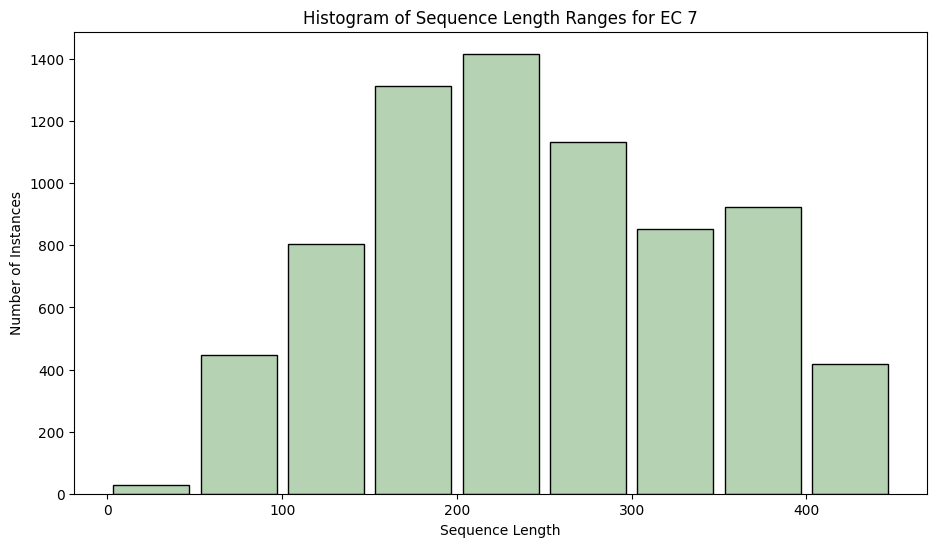

<Figure size 640x480 with 0 Axes>

In [20]:
directory = "/home/saitto/ProGen/all_families/all_families_data/tsvs/ec_7.tsv"
name = "ec_7"
dataframe, mapping_dict = load_data(directory, name=name)

path_hist = "/home/saitto/ProGen/all_families/all_families_data/figures/histograms_lengths/"
_ = plot_histogram(path_hist, dataframe["Length"].to_numpy(), 50, name)

#split the dataframes into training, validation, and test sets for each EC number 90% training, 10% test
train_fraction = 0.9
training, test = split_train_test(dataframe, train_fraction, mapping_dict)

#convert the dataframes to dictionaries
training = convert_to_dict(training)
test = convert_to_dict(test)

#save the dictionaries to pickle files
save_to_pickle(training, "/home/saitto/ProGen/all_families/all_families_data/pickles/training_"+name+ ".p")
save_to_pickle(test, "/home/saitto/ProGen/all_families/all_families_data/pickles/test_"+name+ ".p")


# Blast

In [28]:
import pickle
name = "ec_4"
with open("/home/saitto/ProGen/all_families/all_families_data/pickles/training_"+name+ ".p", "rb") as file:
    training = pickle.load(file)
keys = list(training.keys())
for key in keys[:10]:
    print(key, training[key])

P55250 {'kw': [0, 2], 'ex': 3, 'seq': 'MLRASATRFLSQAKNMNNSPRLFSSASAALQKFRAERDTFGDLQVPADRYWGAQTQRSLQNFDIGGPTERMPEPLIRAFGVLKKAAATVNMTYGLDPKVGEAIQKAADEVIDGSLIDHFPLVVWQTGSGTQTKMNVNEVISNRAIELLGGELGSKAPVHPNDHVNMSQSSNDTFPTAMHVAAVVEIHGRLIPALTTLRDALQAKSAEFEHIIKIGRTHLQDATPLTLGQEFSGYTQQLTYGIARVQGTLERLYNLAQGGTAVGTGLNTRKGFDAKVAEAIASITGLPFKTAPNKFEALAAHDALVEAHGALNTVACSLMKIANDIRYLGSGPRCGLGELSLPENEPGSSIMPGKVNPTQCEAMTMVCAQVMGNNTAISVAGSNGQFELNVFKPVMIKNLIQSIRLISDASISFTKNCVVGIEANEKKISSIMNESLMLVTALNPHIGYDKAAKCAKKAHKEGTTLKEAALSLGYLTSEEFDQWVRPEDMISAKD', 'len': 494}
A1TZ51 {'kw': [0, 5], 'ex': 3, 'seq': 'MRIGQGFDVHAFCEGDSVILGGVTIPHSHGLMAHSDGDVLLHALADALLGAVALGDIGHFFPDSSEEWAGADSRDLLRRVMQRVLDEGYAVTNIDTTIIAQAPKMAPHIEAMRMNIAEDLGVPANRVSVKATTTEKLGFTGRGEGIACQAVCLLEAVSQ', 'len': 159}
P00660 {'kw': [0, 5], 'ex': 5, 'seq': 'KESAAAKFERQHMDSSTSSASSSNYCNQMMKSRNLTQDRCKPVNTFVHEPLADVQAVCSQKNVACKNGQTNCYQSYSTMSITDCRETGSSKYPNCAYKATQAKKHIIVACEGNPYVPVHFDASV', 'len': 124}
P48282 {'kw': [0, 2], 'ex': 4, 'seq': 'MASPDWGYDGENGPEHWCKLHP

### I will use the library of biopython to remove sequences from the test set with a similarity higher than 40% from the training set

In [1]:
import pickle
import os
import subprocess
def save_to_fasta(path_to_load, path_to_save):
    name = path_to_load.split("/")[-1].split(".")[0]
    with open(path_to_load, "rb") as file:
        data = pickle.load(file)
    with open(path_to_save + name + ".fasta", "w") as f:
        for seq_id, seq_info in data.items():
            f.write(f">{seq_id}\n{seq_info['seq']}\n")

training_directories = os.listdir("/home/saitto/ProGen/all_families/all_families_data/pickles")
pickle_path = "/home/saitto/ProGen/all_families/all_families_data/pickles/"
output_path = "/home/saitto/ProGen/all_families/all_families_data/fasta/"
for directory in training_directories:
    save_to_fasta(pickle_path+directory, output_path)


In [3]:
def run_makeblastdb(fasta_path, db_name):
    """Creates a BLAST database from a FASTA file."""
    where_to_save = "/home/saitto/ProGen/all_families/all_families_data/fasta/results/" + 
    if not os.path.exists(where_to_save):
        os.makedirs(where_to_save)
    cmd = [
        '/home/saitto/miniconda3/envs/progen_train/bin/makeblastdb',
        '-in', fasta_path,
        '-dbtype', 'prot',
        '-out', where_to_save + db_name
    ]
    print("the current directory is: ", os.getcwd())
    subprocess.run(cmd)

output_paths = os.listdir("/home/saitto/ProGen/all_families/all_families_data/fasta/")
output_paths = [x for x in output_paths if x.startswith("training")]
for path in output_paths:
    run_makeblastdb("/home/saitto/ProGen/all_families/all_families_data/fasta/"+path, path.split(".")[0])


the current directory is:  /home/saitto/ProGen/all_families/codes


Building a new DB, current time: 03/11/2024 13:53:02
New DB name:   /home/saitto/ProGen/all_families/all_families_data/fasta/db/training_ec_3/training_ec_3
New DB title:  /home/saitto/ProGen/all_families/all_families_data/fasta/training_ec_3.fasta
Sequence type: Protein
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 36089 sequences in 0.546367 seconds.


the current directory is:  /home/saitto/ProGen/all_families/codes


Building a new DB, current time: 03/11/2024 13:53:04
New DB name:   /home/saitto/ProGen/all_families/all_families_data/fasta/db/training_ec_4/training_ec_4
New DB title:  /home/saitto/ProGen/all_families/all_families_data/fasta/training_ec_4.fasta
Sequence type: Protein
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 16612 sequences in 0.250788 seconds.


the current directory is:  /home/saitto/ProGen/all_families/codes


Building a new D

In [43]:
output_paths = os.listdir("/home/saitto/ProGen/all_families/all_families_data/fasta/")
output_paths = [x for x in output_paths if x.startswith("test")]

def run_blastp(query_fasta, db_path, query_name):
    """Runs blastp against a specified database."""
    where_to_save = "/home/saitto/ProGen/all_families/all_families_data/fasta/results/" + query_name +".tsv"
    cmd = [
        '/home/saitto/miniconda3/envs/progen_train/bin/blastp',
        '-query', query_fasta,
        '-db', db_path,
        '-out', where_to_save,
        '-outfmt', "6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qcovs",
        '-max_target_seqs', '1'
    ]
    subprocess.run(cmd)


query_paths = os.listdir("/home/saitto/ProGen/all_families/all_families_data/fasta/")
query_paths = [x for x in output_paths if x.startswith("test")]
#sort the paths by the number e.g. path = test_ec_7.fasta
query_paths = sorted(query_paths, key = lambda x: int(x.split("_")[2].split(".")[0]))
db_paths = os.listdir("/home/saitto/ProGen/all_families/all_families_data/fasta/db/")
db_paths = sorted(db_paths, key = lambda x: int(x[-1]))
db_paths = [x + "/" + x for x in db_paths]
for path_db, path_q in zip(db_paths, query_paths):
    full_path_db = "/home/saitto/ProGen/all_families/all_families_data/fasta/db/"+path_db
    full_path_q = "/home/saitto/ProGen/all_families/all_families_data/fasta/"+path_q
    print(path_q.split(".")[0])
    run_blastp(full_path_q, 
              full_path_db, path_q.split(".")[0])

test_ec_1


test_ec_2


test_ec_3


test_ec_4


test_ec_5


test_ec_6


test_ec_7


In [ ]:
#adding matrix and task and seed
def run_blastp(query_fasta, db_path, query_name, matrix="BLOSUM62", task="blastp-fast", word_size=3):
    """Runs blastp against a specified database with specified options."""
    where_to_save = "/home/saitto/ProGen/all_families/all_families_data/fasta/results/" + query_name + ".tsv"
    cmd = [
        '/home/saitto/miniconda3/envs/progen_train/bin/blastp',
        '-query', query_fasta,
        '-db', db_path,
        '-out', where_to_save,
        '-outfmt', "6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qcovs",
        '-max_target_seqs', '1',
        '-matrix', matrix,
        '-task', task,
        '-word_size', str(word_size)
    ]
    subprocess.run(cmd)
